In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [3]:
df1 = pd.read_csv('churn-bigml-20.csv')
df = pd.read_csv('churn-bigml-80.csv')

In [4]:
def preprocess(df):
  df.columns = df.columns.str.lower().str.replace(' ', '_')
  if 'churn' in df.columns:
    df['churn'] = df.churn.map({False:0, True:1})
  df['total_calls'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls'] + df['total_intl_calls']
  df['total_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes'] + df['total_intl_minutes']
  df['avg_call_duration'] = df['total_minutes'] / (df['total_calls'].replace(0,1))
  df['high_service_calls'] = (df['customer_service_calls'] > 3).astype(int)
  df['total_charge'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge'] + df['total_intl_charge']
  df.drop(['total_day_minutes', 'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes', 'total_minutes','total_eve_charge','total_day_charge'], axis= 1 , inplace= True)
  df.drop(["total_eve_calls", "total_night_calls", "total_calls", 'total_day_calls', "avg_call_duration", "area_code", "state" ], inplace= True, axis= 1)
  df['international_plan'] = df['international_plan'].map({'Yes': 1, 'No': 0})
  df['voice_mail_plan'] = df['voice_mail_plan'].map({'Yes': 1, 'No': 0})


  return df

In [5]:
df=preprocess(df)
df1=preprocess(df1)

In [6]:
df1.shape


(667, 11)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , RobustScaler , StandardScaler , OrdinalEncoder , LabelEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, classification_report
from imblearn.combine import SMOTETomek

In [8]:
X=df.drop('churn',axis=1)
y=df['churn']
X_test=df1.drop('churn',axis=1)
y_test=df1['churn']

In [9]:
X.columns

Index(['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_night_charge', 'total_intl_calls',
       'total_intl_charge', 'customer_service_calls', 'high_service_calls',
       'total_charge'],
      dtype='object')

In [10]:
cat_columns = [ "voice_mail_plan", "international_plan" ]

num_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'churn' in num_columns:
    num_columns.remove('churn')

In [11]:
# checking every models and its performnce

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB , MultinomialNB
from xgboost import XGBClassifier

In [12]:
models = [
        ("DT", DecisionTreeClassifier()) ,
        ("RF", RandomForestClassifier()),
        ("XGB", XGBClassifier()),
        ("SVM", SVC()),
        ("KNN", KNeighborsClassifier()),
]

In [13]:

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [14]:
# handling imbalancing data

from collections import Counter

print("Before:", Counter(y))
X_res, y_res = SMOTETomek(smote=SMOTE(sampling_strategy={1: 1820}, random_state=24)).fit_resample(X,y)
print("After SMOTETomek:", Counter(y_res))


Before: Counter({0: 2278, 1: 388})
After SMOTETomek: Counter({0: 2225, 1: 1767})


In [15]:
# scoring metrics for evaluation

scoring = {
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',  OrdinalEncoder(), cat_columns),
        ('num_scaling', RobustScaler(), num_columns )
    ],
    remainder='passthrough'
)

In [16]:
# ml pipeline for model selection

for model in models:
    # Build pipeline with preprocessing, SMOTETomek, and the model
    steps = [
   ('preprocessing', preprocessor),
   ("SmoteTomek", SMOTETomek(smote=SMOTE(sampling_strategy={1: 1820}, random_state=24))),
   (model)
]

    pipeline = Pipeline(steps= steps)  # Apply all pipeline steps and saved to use in CV

     # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
    result = cross_validate(pipeline, X, y, cv= skf, scoring= scoring, return_train_score= True)

    # Average recall
    print(f"{model[0]} Average Train Recall: {result['train_recall'].mean():.4f}")
    print(f"{model[0]} Average Test Recall: {result['test_recall'].mean():.4f}")

    # Average accuracy
    print(f"{model[0]} Average Train Accuracy: {result['train_accuracy'].mean():.4f}")
    print(f"{model[0]} Average Test Accuracy: {result['test_accuracy'].mean():.4f}")

    # Average precision
    print(f"{model[0]} Average Train Precision: {result['train_precision'].mean():.4f}")
    print(f"{model[0]} Average Test Precision: {result['test_precision'].mean():.4f}\n")

DT Average Train Recall: 0.9929
DT Average Test Recall: 0.8556
DT Average Train Accuracy: 0.9981
DT Average Test Accuracy: 0.9329
DT Average Train Precision: 0.9942
DT Average Test Precision: 0.7339

RF Average Train Recall: 0.9929
RF Average Test Recall: 0.8556
RF Average Train Accuracy: 0.9989
RF Average Test Accuracy: 0.9734
RF Average Train Precision: 0.9994
RF Average Test Precision: 0.9583

XGB Average Train Recall: 0.9929
XGB Average Test Recall: 0.8505
XGB Average Train Accuracy: 0.9986
XGB Average Test Accuracy: 0.9730
XGB Average Train Precision: 0.9974
XGB Average Test Precision: 0.9601

SVM Average Train Recall: 0.8679
SVM Average Test Recall: 0.8119
SVM Average Train Accuracy: 0.9237
SVM Average Test Accuracy: 0.9066
SVM Average Train Precision: 0.6888
SVM Average Test Precision: 0.6433

KNN Average Train Recall: 0.9858
KNN Average Test Recall: 0.7628
KNN Average Train Accuracy: 0.9134
KNN Average Test Accuracy: 0.8458
KNN Average Train Precision: 0.6292
KNN Average Test P

In [17]:
# chossing random forest as final model

# pipline with our final model
steps = [
     ('preprocessing', preprocessor),
     ("SmoteTomek", SMOTETomek(smote=SMOTE(sampling_strategy={1: 1820}, random_state=24))),
     ("RF" ,  RandomForestClassifier())
]

pipeline = Pipeline(steps= steps)

In [18]:
#handling Overfitting

param_grid = {
    'RF__n_estimators': [180, 200, 250],
    'RF__max_depth': [9 , 10,  11],
    'RF__min_samples_split': [ 16 , 14 ,18],
    'RF__min_samples_leaf': [2, 4, 6]
}

scorers = {
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score)
}

# Cross validation + GridSearchCV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
grid = GridSearchCV( estimator= pipeline, param_grid= param_grid, cv= skf, scoring= scorers, refit='recall',  return_train_score= True )


result = grid.fit(X_res, y_res)

In [19]:
print(
    # Acc
    f"Train Acc: {result.cv_results_['mean_train_accuracy'][result.best_index_]:.4f} | "
    f"Test Acc: {result.cv_results_['mean_test_accuracy'][result.best_index_]:.4f} | "

    # recall
    f"Train Recall: {result.cv_results_['mean_train_recall'][result.best_index_]:.4f} | "
    f"Test Recall: {result.cv_results_['mean_test_recall'][result.best_index_]:.4f} | "

      # Precision
    f"Train Precision: {result.cv_results_['mean_train_precision'][result.best_index_]:.4f} | "
    f"Test Precision: {result.cv_results_['mean_test_precision'][result.best_index_]:.4f}"
)

Train Acc: 0.9180 | Test Acc: 0.8895 | Train Recall: 0.8250 | Test Recall: 0.7753 | Train Precision: 0.9877 | Test Precision: 0.9690


In [20]:
pipeline.set_params(**result.best_params_)

,steps,"[('preprocessing', ...), ('SmoteTomek', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num_scaling', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [21]:
Final_Model = pipeline.fit(X_res, y_res)

In [22]:
y_pred =Final_Model.predict(X_test)

# 6. EVALUATION METRICS
acc = accuracy_score(y_test, y_pred)
print(f"\n Model Accuracy: {acc:.2%}")
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred))


 Model Accuracy: 97.75%

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       572
           1       0.97      0.87      0.92        95

    accuracy                           0.98       667
   macro avg       0.97      0.93      0.95       667
weighted avg       0.98      0.98      0.98       667



In [23]:
import seaborn as sns

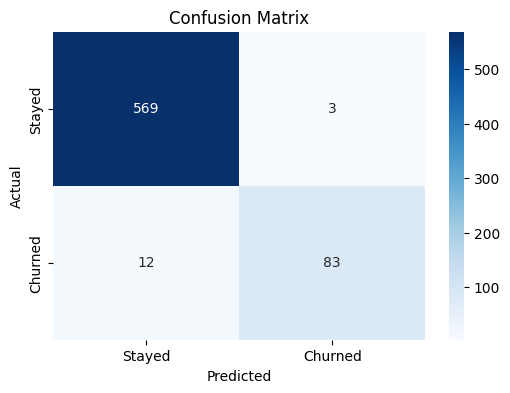

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stayed', 'Churned'], yticklabels=['Stayed', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [25]:
import joblib
joblib.dump(Final_Model, "final_model.pkl")


['final_model.pkl']

In [26]:
import pandas as pd
test_data='churn-bigml-20.csv'
pred_df=pd.read_csv(test_data)
new=pred_df.drop(['Churn'],axis=1)
new

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,WI,114,415,No,Yes,26,137.1,88,23.31,155.7,125,13.23,247.6,94,11.14,11.5,7,3.11,2
663,AL,106,408,No,Yes,29,83.6,131,14.21,203.9,131,17.33,229.5,73,10.33,8.1,3,2.19,1
664,VT,60,415,No,No,0,193.9,118,32.96,85.0,110,7.23,210.1,134,9.45,13.2,8,3.56,3
665,WV,159,415,No,No,0,169.8,114,28.87,197.7,105,16.80,193.7,82,8.72,11.6,4,3.13,1


In [27]:
def preprocess(df):
  df.columns = df.columns.str.lower().str.replace(' ', '_')
  if 'churn' in df.columns:
    df['churn'] = df.churn.map({False:0, True:1})
  df['total_calls'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls'] + df['total_intl_calls']
  df['total_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes'] + df['total_intl_minutes']
  df['avg_call_duration'] = df['total_minutes'] / (df['total_calls'].replace(0,1))
  df['high_service_calls'] = (df['customer_service_calls'] > 3).astype(int)
  df['total_charge'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge'] + df['total_intl_charge']
  df.drop(['total_day_minutes', 'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes', 'total_minutes','total_eve_charge','total_day_charge'], axis= 1 , inplace= True)
  df.drop(["total_eve_calls", "total_night_calls", "total_calls", 'total_day_calls', "avg_call_duration", "area_code", "state" ], inplace= True, axis= 1)
  df['international_plan'] = df['international_plan'].map({'Yes': 1, 'No': 0})
  df['voice_mail_plan'] = df['voice_mail_plan'].map({'Yes': 1, 'No': 0})


  return df

In [28]:
new_df=preprocess(new)
new_df

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_night_charge,total_intl_calls,total_intl_charge,customer_service_calls,high_service_calls,total_charge
0,117,0,0,0,9.71,4,2.35,1,0,73.32
1,65,0,0,0,9.40,6,3.43,4,1,54.20
2,161,0,0,0,7.23,9,1.46,4,1,92.29
3,111,0,0,0,8.53,6,2.08,2,0,41.05
4,49,0,0,0,8.04,1,3.00,1,0,49.60
...,...,...,...,...,...,...,...,...,...,...
662,114,0,1,26,11.14,7,3.11,2,0,50.79
663,106,0,1,29,10.33,3,2.19,1,0,44.06
664,60,0,0,0,9.45,8,3.56,3,0,53.20
665,159,0,0,0,8.72,4,3.13,1,0,57.52


In [29]:
import joblib
model = joblib.load("final_model.pkl")
processed_data=new_df.copy()
churn_prediction=model.predict(processed_data)
results_df = pred_df.copy()
results_df['predicted_churn_class'] = churn_prediction
results_df['predicted_churn_label'] = results_df['predicted_churn_class'].map({
    0: 'Will Not Churn',
    1: 'Will Churn'
})
print(results_df)

    State  Account length  Area code International plan Voice mail plan  \
0      LA             117        408                 No              No   
1      IN              65        415                 No              No   
2      NY             161        415                 No              No   
3      SC             111        415                 No              No   
4      HI              49        510                 No              No   
..    ...             ...        ...                ...             ...   
662    WI             114        415                 No             Yes   
663    AL             106        408                 No             Yes   
664    VT              60        415                 No              No   
665    WV             159        415                 No              No   
666    CT             184        510                Yes              No   

     Number vmail messages  Total day minutes  Total day calls  \
0                        0       

In [30]:
results_df.to_csv("result2.csv",index=False)